In [1]:
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np 
import random
import seaborn as sns
import warnings
import time

import tensorflow as tf
from tensorflow.keras.layers import *
# Oversampling
from imblearn.over_sampling import RandomOverSampler
import sklearn
warnings.filterwarnings("ignore")

In [2]:
seed = 101
tf.random.set_seed(seed)

In [3]:
df = pd.read_csv(r'dataset_fix2.csv', header=0)
df = df.drop(['no', 'bloodPressure'], axis=1)


In [4]:
df

,age,gender,respirartoryRate,HeartRate,temperature,hypertension,dm,heartDisease,smoking,STROKE
0,76,P,20,88,36.0,1,1,1,0,1
1,68,p,23,70,36.0,1,1,1,0,1
2,62,p,20,83,36.8,1,1,0,0,1
3,54,L,22,88,37.0,1,0,0,0,1
4,83,L,18,82,36.8,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...
1550,63,P,20,95,35.5,1,0,0,0,0
1551,60,L,20,75,36.7,0,0,1,0,0
1552,50,L,18,80,36.8,0,0,1,0,0
1553,53,L,22,70,37.2,1,0,0,0,0


In [5]:
df.describe()

,age,respirartoryRate,HeartRate,temperature,hypertension,dm,heartDisease,smoking,STROKE
count,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000
mean,52.829582,20.181994,77.218650,36.510611,0.362058,0.022508,0.158199,0.278457,0.099035
std,9.369569,1.748965,12.981317,0.903936,0.480750,0.148376,0.365045,0.448384,0.298806
min,32.000000,18.000000,50.000000,35.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,46.000000,19.000000,69.000000,35.700000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,52.000000,20.000000,75.000000,36.500000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,60.000000,21.000000,85.000000,37.300000,1.000000,0.000000,0.000000,1.000000,0.000000
max,92.000000,40.000000,155.000000,39.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0.5, 1.0, 'Class Frequency\n0 : no stroke\n1: stroke')

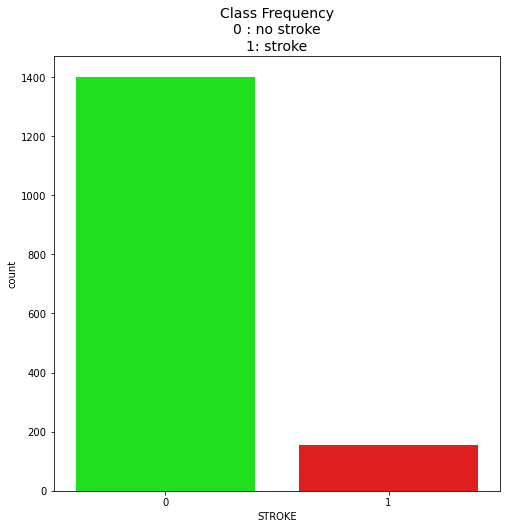

In [6]:
colors = ["#00FF00", "#FF0000"]
fig, ax = plt.subplots(figsize=(8,8))
sns.countplot('STROKE', data=df, ax=ax, palette=colors)
plt.title('Class Frequency\n0 : no stroke\n1: stroke', fontsize=14)

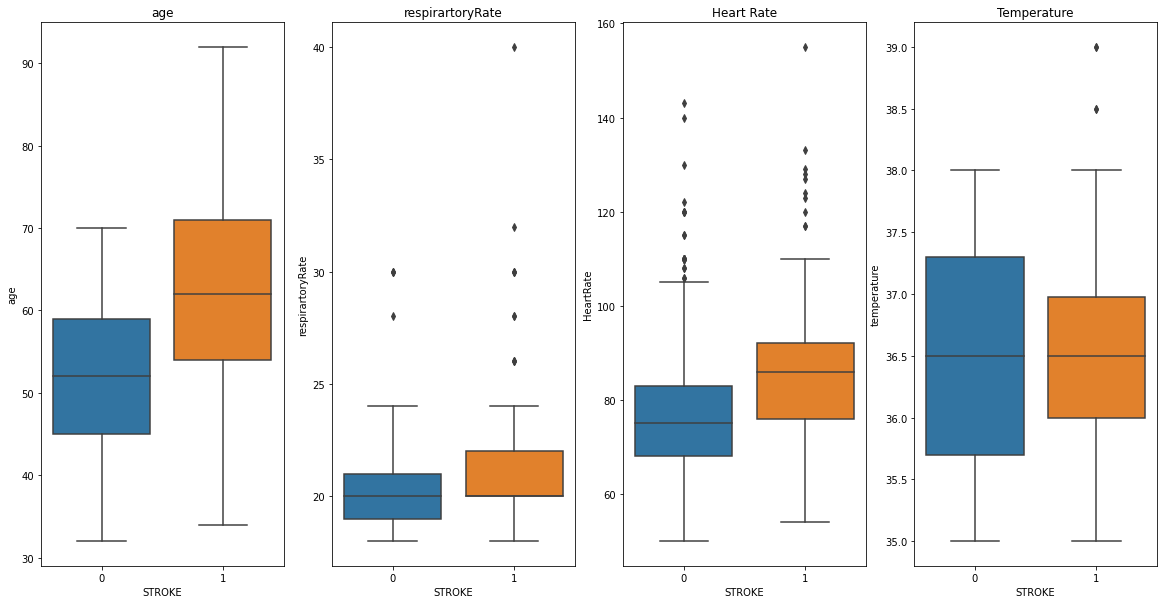

In [7]:
f, axes= plt.subplots(1, 4, figsize = (20, 10))
sns.boxplot(x="STROKE", y="age", data =df, ax=axes[0]).set_title('age')
sns.boxplot(x="STROKE", y="respirartoryRate", data =df, ax=axes[1]).set_title('respirartoryRate')
sns.boxplot(x="STROKE", y="HeartRate", data=df, ax=axes[2]).set_title('Heart Rate')
sns.boxplot(x="STROKE", y="temperature", data=df, ax=axes[3]).set_title('Temperature')
plt.show()

# Convert categorical values to numeric

In [8]:
gender = {'L': 0, 'l' : 0, 'P': 1, 'p' : 1}
df['gender'] = df['gender'].map(gender)

In [9]:
df.head()

,age,gender,respirartoryRate,HeartRate,temperature,hypertension,dm,heartDisease,smoking,STROKE
0,76,1,20,88,36.0,1,1,1,0,1
1,68,1,23,70,36.0,1,1,1,0,1
2,62,1,20,83,36.8,1,1,0,0,1
3,54,0,22,88,37.0,1,0,0,0,1
4,83,0,18,82,36.8,1,0,0,1,1


In [10]:
X = df
y = X.pop('STROKE')

# Intialize Model

In [11]:
def baseline_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(len(X.columns),)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])
    return model

In [12]:
model = baseline_model()

In [13]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=seed)

In [14]:
model.fit(X_train, y_train, epochs=15, batch_size=64)

Train on 1244 samples
Epoch 1/15
1244/1244 [==============================] - 2s 2ms/sample - loss: 1.8789 - accuracy: 0.7733
Epoch 2/15
1244/1244 [==============================] - 0s 78us/sample - loss: 0.4407 - accuracy: 0.8979
Epoch 3/15
1244/1244 [==============================] - 0s 90us/sample - loss: 0.3089 - accuracy: 0.9068
Epoch 4/15
1244/1244 [==============================] - 0s 75us/sample - loss: 0.3001 - accuracy: 0.9068
Epoch 5/15
1244/1244 [==============================] - 0s 63us/sample - loss: 0.2729 - accuracy: 0.9084
Epoch 6/15
1244/1244 [==============================] - 0s 87us/sample - loss: 0.2668 - accuracy: 0.9076
Epoch 7/15
1244/1244 [==============================] - 0s 91us/sample - loss: 0.2785 - accuracy: 0.9172
Epoch 8/15
1244/1244 [==============================] - 0s 113us/sample - loss: 0.2749 - accuracy: 0.9140
Epoch 9/15
1244/1244 [==============================] - 0s 118us/sample - loss: 0.2344 - accuracy: 0.9204
Epoch 10/15
1244/1244 [=========

In [15]:
y_pred = model.predict_classes(X_test)
report = sklearn.metrics.classification_report(y_test, y_pred.flatten())
print(report)

precision    recall  f1-score   support

           0       0.92      0.99      0.95       273
           1       0.82      0.37      0.51        38

    accuracy                           0.91       311
   macro avg       0.87      0.68      0.73       311
weighted avg       0.91      0.91      0.90       311



# Cross Validation

In [16]:
# Fit Model
EPOCHS = 30
BATCH_SIZE = 64

In [17]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

train_acc = []
test_acc = []
history = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train , y_train = RandomOverSampler(random_state=seed).fit_resample(X_train, y_train)
    model = baseline_model()
    history += [model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE).history['accuracy']]
    
    m = tf.keras.metrics.Accuracy()
    m.update_state(model.predict_classes(X_train), y_train)
    trainScore = m.result().numpy()

    m = tf.keras.metrics.Accuracy()
    m.update_state(model.predict_classes(X_test), y_test)
    testScore = m.result().numpy()

    train_acc.append(trainScore)
    test_acc.append(testScore)

Train on 2242 samples
Epoch 1/30
2242/2242 [==============================] - 1s 498us/sample - loss: 2.2377 - accuracy: 0.5089
Epoch 2/30
2242/2242 [==============================] - 0s 124us/sample - loss: 0.6345 - accuracy: 0.6258
Epoch 3/30
2242/2242 [==============================] - 0s 95us/sample - loss: 0.5712 - accuracy: 0.6909
Epoch 4/30
2242/2242 [==============================] - 0s 96us/sample - loss: 0.5443 - accuracy: 0.7136
Epoch 5/30
2242/2242 [==============================] - 1s 226us/sample - loss: 0.5300 - accuracy: 0.7194
Epoch 6/30
2242/2242 [==============================] - 0s 80us/sample - loss: 0.5175 - accuracy: 0.7351
Epoch 7/30
2242/2242 [==============================] - 0s 81us/sample - loss: 0.5534 - accuracy: 0.7079
Epoch 8/30
2242/2242 [==============================] - 0s 72us/sample - loss: 0.5071 - accuracy: 0.7324
Epoch 9/30
2242/2242 [==============================] - 0s 64us/sample - loss: 0.5260 - accuracy: 0.7319
Epoch 10/30
2242/2242 [=======

Text(0.5, 1.0, 'Class Frequency\n0 : no stroke\n1: stroke')

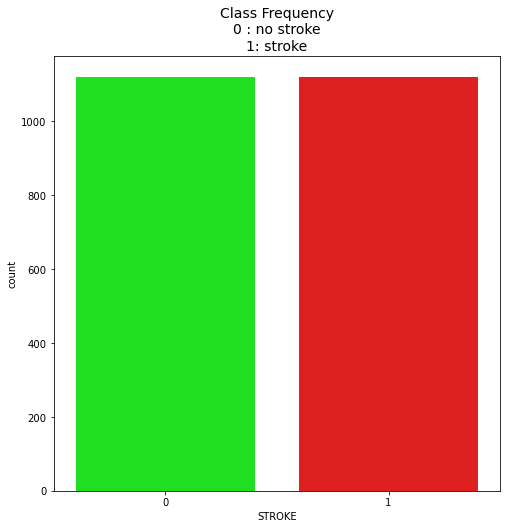

In [18]:
colors = ["#00FF00", "#FF0000"]
fig, ax = plt.subplots(figsize=(8,8))
sns.countplot('STROKE', data=pd.concat([X_train,y_train], axis=1), ax=ax, palette=colors)
plt.title('Class Frequency\n0 : no stroke\n1: stroke', fontsize=14)

In [19]:
model=baseline_model()
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

Train on 2240 samples
Epoch 1/30
2240/2240 [==============================] - 1s 282us/sample - loss: 0.7321 - accuracy: 0.6531
Epoch 2/30
2240/2240 [==============================] - 0s 65us/sample - loss: 0.5067 - accuracy: 0.7496
Epoch 3/30
2240/2240 [==============================] - 0s 66us/sample - loss: 0.5232 - accuracy: 0.7321
Epoch 4/30
2240/2240 [==============================] - 0s 72us/sample - loss: 0.5433 - accuracy: 0.7210
Epoch 5/30
2240/2240 [==============================] - 0s 60us/sample - loss: 0.4750 - accuracy: 0.7732
Epoch 6/30
2240/2240 [==============================] - 0s 67us/sample - loss: 0.4935 - accuracy: 0.7500
Epoch 7/30
2240/2240 [==============================] - 0s 67us/sample - loss: 0.4785 - accuracy: 0.7674
Epoch 8/30
2240/2240 [==============================] - 0s 68us/sample - loss: 0.4834 - accuracy: 0.7603
Epoch 9/30
2240/2240 [==============================] - 0s 64us/sample - loss: 0.4654 - accuracy: 0.7759
Epoch 10/30
2240/2240 [=========

In [21]:
y_pred = model.predict_classes(X_test)
report = sklearn.metrics.classification_report(y_test, y_pred.flatten())
print(report)

precision    recall  f1-score   support

           0       0.95      0.86      0.90       281
           1       0.30      0.57      0.39        30

    accuracy                           0.83       311
   macro avg       0.62      0.71      0.65       311
weighted avg       0.89      0.83      0.85       311



In [22]:
train_acc

[0.75646746, 0.7925959, 0.7738626, 0.7894737, 0.7910714]

In [23]:
test_acc

[0.87138265, 0.7620579, 0.8842444, 0.7749196, 0.8327974]

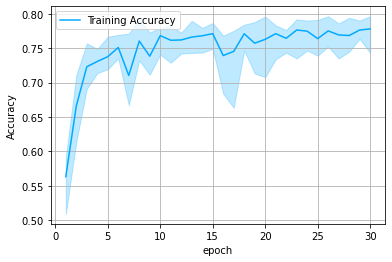

In [24]:
f, ax = plt.subplots()

ax.fill_between(range(1, EPOCHS+1), np.max(history, axis=0), np.min(history,axis=0) , alpha=0.25, color="#00aaff")

ax.plot(range(1, EPOCHS+1), np.average(history, axis=0), color="#00aaff", label="Training Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('epoch')
ax.legend()
ax.grid(True)


In [25]:
# cross validation training accuracy
np.mean(train_acc)

0.78069425

In [26]:
# cross validation testing accuracy
np.mean(test_acc)

0.8250804

In [27]:
X_test = X_test.reset_index().drop(['index'], axis=1)

## Predict individual sample

In [28]:
index = 3 # or any other number

In [29]:
test_sample = X_test.loc[index]
test_sample = np.array(test_sample).reshape(1, -1)

In [30]:
test_sample

array([[67.,  0., 24., 72., 37.,  0.,  1.,  1.,  0.]])

In [31]:
model.predict(test_sample)

array([[0.9912315]], dtype=float32)

In [32]:
y_test.reset_index().drop(['index'], axis=1).loc[index]

STROKE    1
Name: 3, dtype: int64

In [33]:
#model.save_weights('sesuatu')

In [34]:
from firebase import firebase
firebase = firebase.FirebaseApplication('https://stroke-25f59.firebaseio.com', None)

In [35]:
riskfactors = firebase.get('/riskFactors', None)
vitalsigns = firebase.get('/vitalsigns', None)

In [36]:
df = pd.DataFrame(riskfactors.values()).T
df.columns=riskfactors.keys()
df

,age,dm,gender,heartDisease,hypertension,name,smoking
0,24,False,False,False,False,Novhel,False


In [37]:
df['smoking'] = df['smoking'].astype(int)
df['dm'] = df['dm'].astype(int)
df['gender'] = df['gender'].astype(int)
df['heartDisease'] = df['heartDisease'].astype(int)
df['hypertension'] = df['hypertension'].astype(int)
df = df.drop('name', axis=1)

In [38]:
df

,age,dm,gender,heartDisease,hypertension,smoking
0,24,0,0,0,0,0


In [39]:
df2 = pd.DataFrame(vitalsigns.values()).T
df2.columns=vitalsigns.keys()
df2

,heartRate,respiratoryRate,temperature
0,88.0,12.0,36.5


In [40]:
df = pd.concat([df,df2], axis=1)
df = df[['age', 'gender', 'respiratoryRate', 'heartRate', 'temperature', 'hypertension', 'dm', 'heartDisease', 'smoking']]


In [41]:
df

,age,gender,respiratoryRate,heartRate,temperature,hypertension,dm,heartDisease,smoking
0,24,0,12.0,88.0,36.5,0,0,0,0


## Predict from Db

In [42]:
inputX = df.loc[0]
inputX = np.array(inputX, dtype=np.int).reshape(1, -1)

In [43]:
inputX

array([[24,  0, 12, 88, 36,  0,  0,  0,  0]])

In [44]:
model.predict(inputX)

array([[0.2947376]], dtype=float32)

In [48]:
model.predict(inputX)

array([[0.2947376]], dtype=float32)

In [46]:
X.loc[0]

age                 76.0
gender               1.0
respirartoryRate    20.0
HeartRate           88.0
temperature         36.0
hypertension         1.0
dm                   1.0
heartDisease         1.0
smoking              0.0
Name: 0, dtype: float64

In [47]:
df.loc[0]

age                  24
gender                0
respiratoryRate      12
heartRate            88
temperature        36.5
hypertension          0
dm                    0
heartDisease          0
smoking               0
Name: 0, dtype: object